<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: Илья Барышников (@lucidyan), Максим Уваров (maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №2. Решение
## <center> Визуальный анализ данных о сердечно-сосудистых заболеваниях

В соревновании предлагалось определить наличие/отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам осмотра пациента.

**Описание данных.**

Датасет сформирован из реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:

 - Возраст (age)
 - Рост (height)
 - Вес (weight)
 - Пол (gender)
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
 - Холестерин (cholesterol)
 - Глюкоза (gluc)
 

Субъективные признаки (со слов пациентов):

 - Курение (smoke)
 - Употребление алкоголя (alco)
 - Физическая активность (active)
 
Целевой признак (который интересно будет прогнозировать):
 - Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [3]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# игнорируем warnings
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = {
        "axes.titlesize" : 18 
    }
)

sns.set_style('darkgrid')

# константа для задания размеров графиков
FIGSIZE_TUPLE = (12, 9)

В рамках задания, для простоты, будем работать только с train-выборкой
<br>
<br>
Все визуализации рекомендуется производить с помощью библиотеки **seaborn**

# Проведем небольшой EDA

In [4]:
train = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';')

In [5]:
print('Размер датасета: ', train.shape)
train.head()

Размер датасета:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Для начала, всегда неплохо бы посмотреть на значения, которые принимают переменные

Переведем данные в "Long Format"-представление и отрисуем с помощью [factorplot](https://seaborn.pydata.org/generated/seaborn.factorplot.html) количество значений, которые принимают категориальные переменные

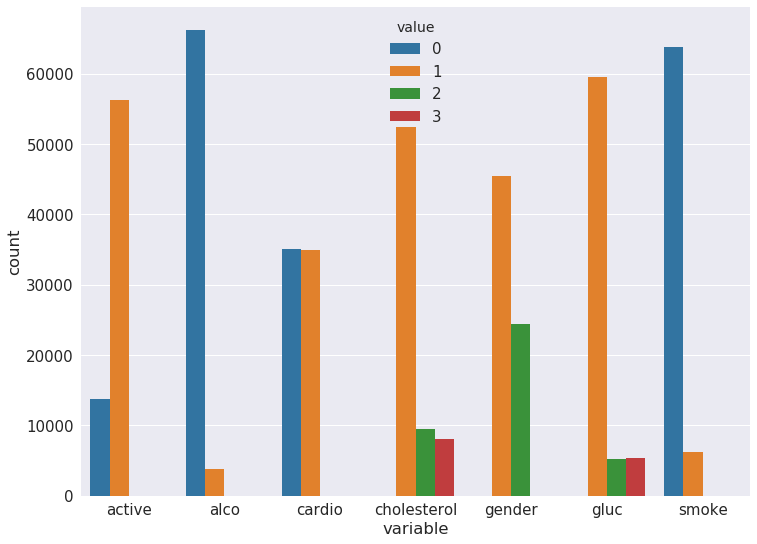

In [6]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])
train_uniques = (
    pd.DataFrame(
        train_uniques.groupby(['variable', 'value'])['value'].count()
    )
    .sort_index(level=[0, 1])
    .rename(columns={'value': 'count'})
    .reset_index()
)

fig, ax = plt.subplots(figsize=FIGSIZE_TUPLE)
sns.factorplot(x='variable', y='count', hue='value', 
               data=train_uniques, kind='bar', ax=ax)
plt.clf();

Видим, что классы целевой переменно сбалансированы, отлично!

Можно так же разбить элементы обучающей выборки по значениям целевой переменной: иногда на таких графиках можно сразу увидеть самый значимый признак

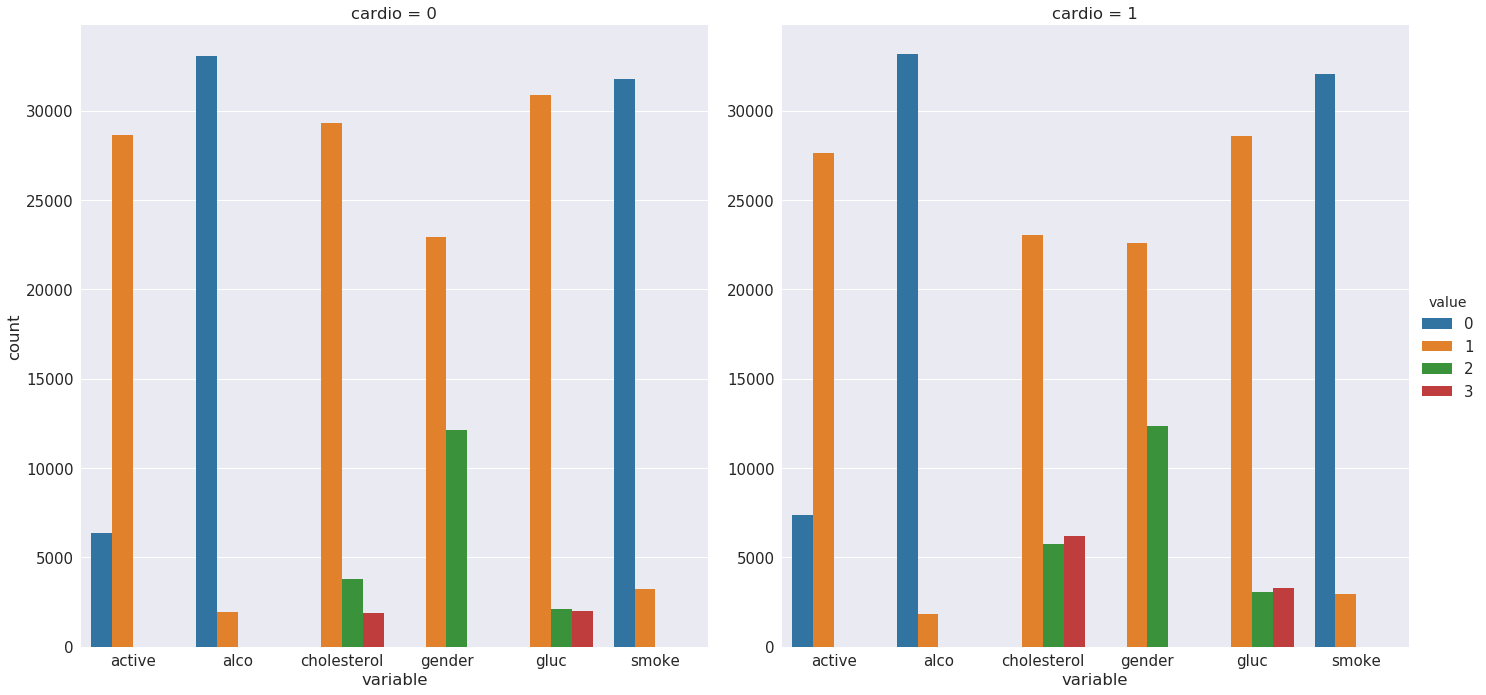

In [7]:
train_uniques = pd.melt(frame=train, 
                        value_vars=[
                            'gender','cholesterol', 'gluc', 
                            'smoke', 'alco', 'active'
                        ], 
                        id_vars=['cardio']
)

train_uniques = (
    pd.DataFrame(
        train_uniques.groupby(['variable', 'value', 'cardio'])['value'].count()
    )
    .sort_index(level=[0, 1])
    .rename(columns={'value': 'count'})
    .reset_index()
)
    
sns.factorplot(x='variable', y='count', hue='value', col='cardio', 
               data=train_uniques, kind='bar', size=10);

Видим, что сильно меняется распределение холестерина и глюкозы в зависимости от целевой переменной. Совпадение?

**Немного статистики по уникальным значениям признаков**

In [8]:
for c in train.columns:
    n = train[c].nunique()
    print(c)
    
    if n <= 3:
        print(n, sorted(train[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '_')

id
70000
__________
age
8076
__________
gender
2 [(1, 45530), (2, 24470)]
__________
height
109
__________
weight
287
__________
ap_hi
153
__________
ap_lo
157
__________
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
__________
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
__________
smoke
2 [(0, 63831), (1, 6169)]
__________
alco
2 [(0, 66236), (1, 3764)]
__________
active
2 [(0, 13739), (1, 56261)]
__________
cardio
2 [(0, 35021), (1, 34979)]
__________


*Итого:*
- Пять количественных признаков (без id)
- Семь категориальных
- 70000 элементов

---

# 1. Визуализируем корреляционную матрицу

Для того, чтобы лучше понять признаки в датасете, можно посчитать матрицу коэффициентов корреляции между признаками. <br>

Постройте [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) корреляционной матрицы. Матрица формируется средствами *pandas*, со стандартным значением параметров.

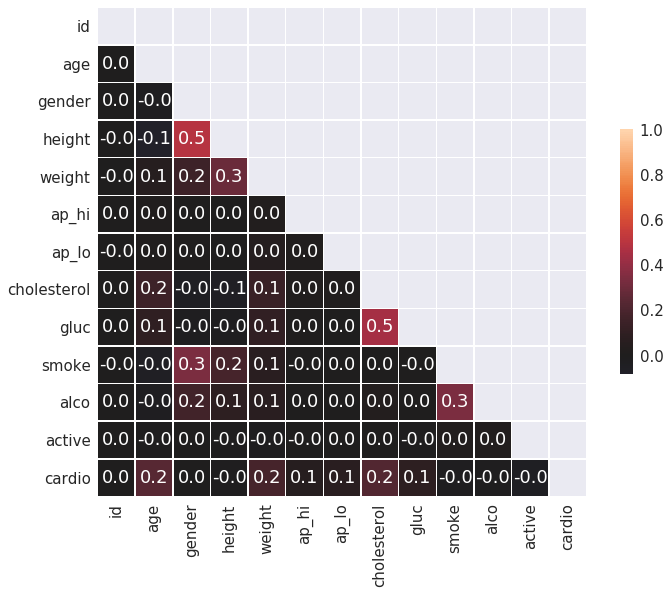

In [9]:
# Вычисляем матрицу корреляций
corr = train.corr(method='pearson')

# Генерируем маску для отсечения верхней диагонали матрицы
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=FIGSIZE_TUPLE)

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

###  1. Какие два признака больше всего коррелируют (по Пирсону) с признаком `height` ?

- Gluc, Cholesterol
- Weight, Alco
- Smoke, Alco
- **<font color='green'>Weight, Gender</font>**

---

# 2. Распределение роста для мужчин и женщин

Как мы увидели в процессе исследования уникальных значений, пол кодируется значениями 1 и 2, расшифровка изначально не была нам дана в описании данных, но мы догадались, кто есть кто, посчитав средние значения роста (или веса) при разных значениях признака `gender`. Теперь сделаем то же самое, но графически. 

Постройте [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) для наиболее коррелирующего (по Пирсону) с гендером признака. Используйте параметры: 
- hue - для разбивки по полу
- scale - для оценки количества каждого из полов 

Для корректной отрисовки, преобразуйте DataFrame в "Long Format" - представление, с помощью функции [melt](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) в pandas
<br>
У вас должен получиться один ассиметричный violinplot, с плотностями распределений разных полов по обе стороны графика. ([пример](https://stackoverflow.com/a/41575149/3338479))

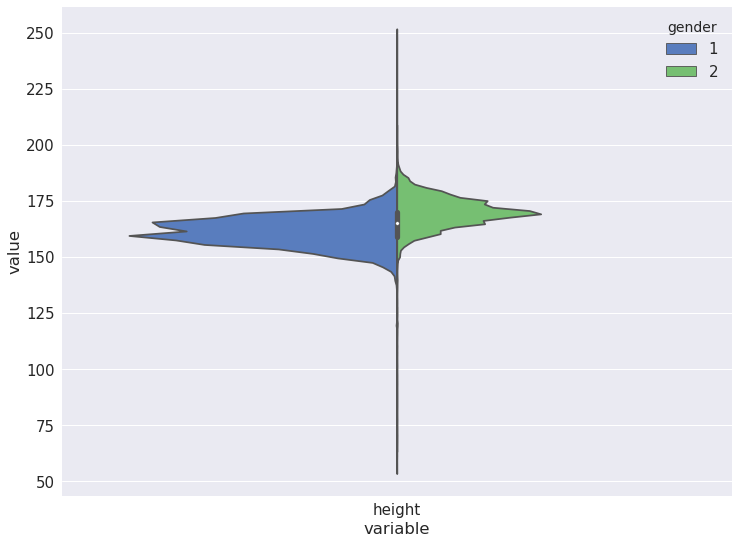

In [10]:
train_melt = pd.melt(frame=train, value_vars=['height'], id_vars=['gender'])

plt.figure(figsize=FIGSIZE_TUPLE)
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    palette="muted", 
    split=True, 
    data=train_melt, 
    scale='count',
    scale_hue=False
)

Постройте на одном графике два отдельных одномерных (univariate) [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) для того же признака, для каждого из гендеров. На нем разница будет более наглядной, но нельзя будет оценить количество элементов каждого гендера.

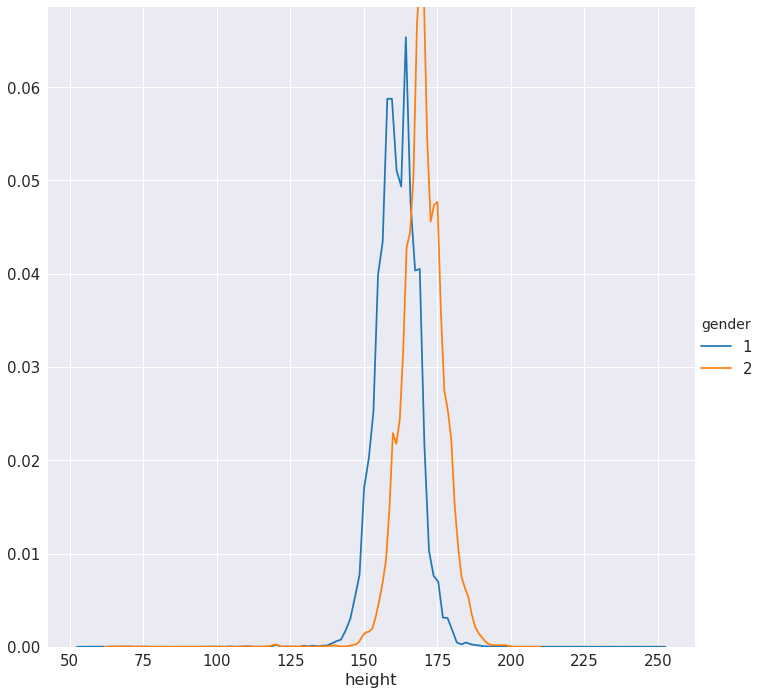

In [11]:
(
    sns.FacetGrid(train, hue="gender", size=10)
        .map(sns.kdeplot, "height")
        .add_legend()
);

---

# 3. Ранговая корреляция

В большинстве случаев достаточно воспользоваться линейный коэффициент корреляции *Пирсона* для выявления закономерностей в данных, но мы пойдем чуть дальше и используем ранговую корреляцию, которая поможет нам выявить пары, в которых меньший ранг из вариационного ряда одного признака, всегда предшествует большему другого (или наоборот, в случае отрицательной корреляции).

##### Постройте корреляционную матрицу, используя коэффициент Спирмена

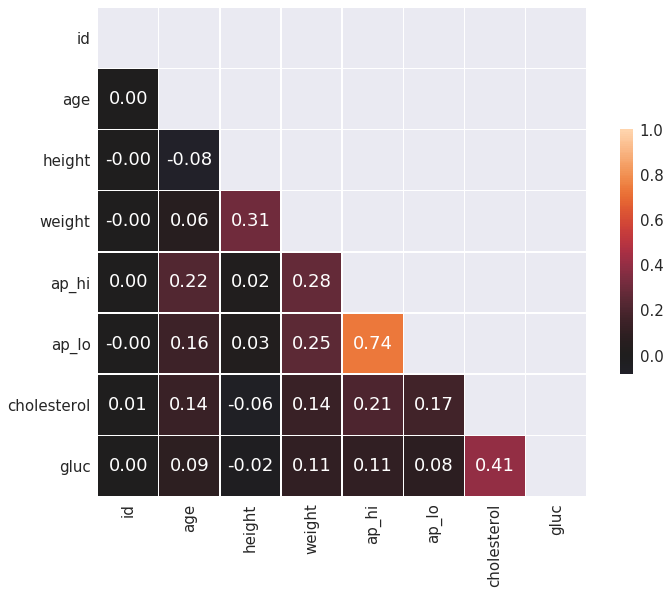

In [12]:
corr = train[
    [
        'id', 'age', 'height', 'weight', 
        'ap_hi', 'ap_lo', 'cholesterol', 
        'gluc'
    ]
].corr(method='spearman')

# Маска для закрытия верхнего треугольника матрицы корреляций (матрица симметрична)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=FIGSIZE_TUPLE)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### 3.1 Какие признаки теперь больше всего коррелируют (по Спирмену) друг с другом?

- Height, Weight
- Age, Weight
- **<font color='green'>Ap_hi, Ap_lo</font>**
- Cholesterol, Gluc
- Cardio, Cholesterol
- Smoke, Alco

### 3.2 Почему мы получили такое большое (относительно) значение ранговой корреляции у этих признаков?

- Неточности в данных (ошибки при сборе данных)
- Связь ошибочна, переменные никак не должны быть связаны друг с другом
- **<font color='green'>Природа данных</font>**

---

# 4. Совместное распределение признаков

Постройте совместный график распределения [jointplot](http://seaborn.pydata.org/generated/seaborn.jointplot.html) двух наиболее коррелирующих между собой признаков (по Спирмену).

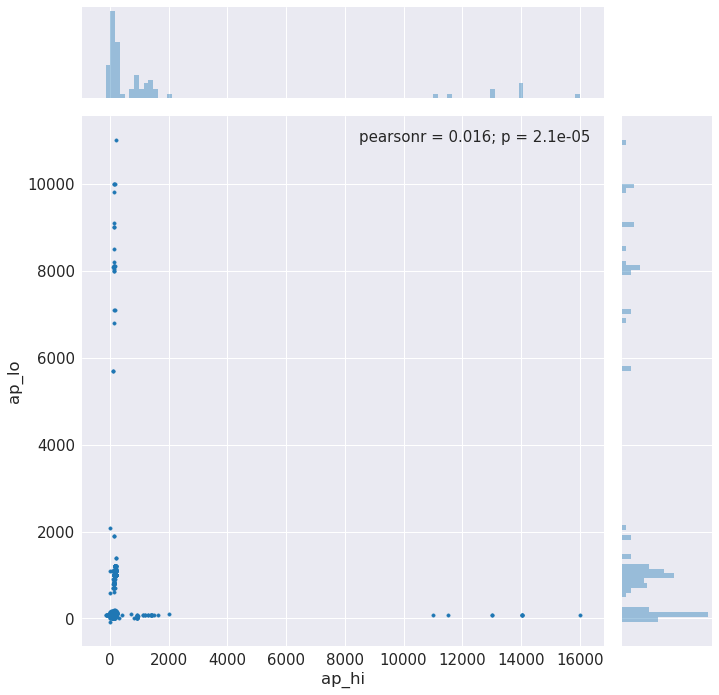

In [13]:
sns.jointplot(
    train['ap_hi'], 
    train['ap_lo'], 
    size=10, 
    marker='.',
    marginal_kws=dict(bins=100, rug=False, hist_kws={'log': True}),  # Параметры гистограммы
);

Кажется, наш график получился неинформативным из-за выбросов в значениях. Постройте тот же график, предварительно прологарифмируя значения.

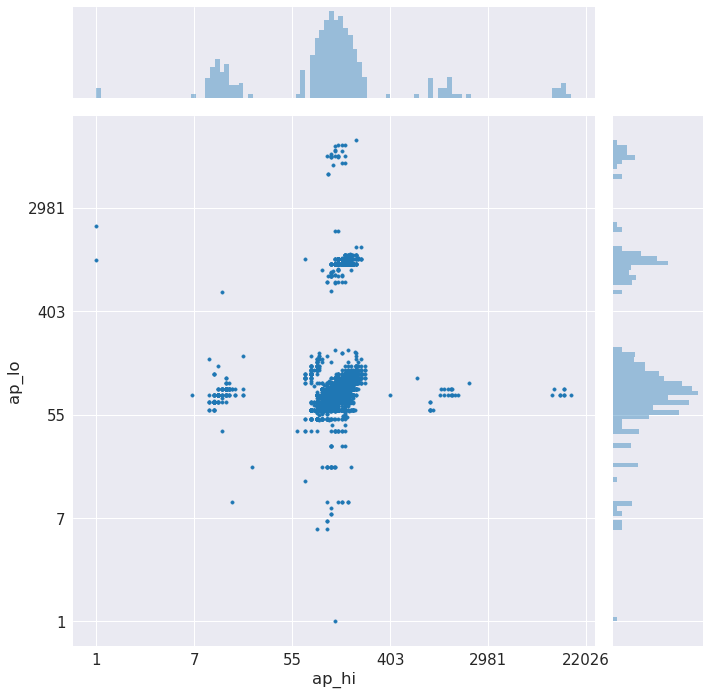

In [14]:
# ---- Ваш код ------- #
tmp_train = train[(train['ap_hi'] > 0) & (train['ap_lo'] > 0)][['ap_lo', 'ap_hi']].apply(np.log)
g = sns.jointplot(
    tmp_train['ap_hi'], 
    tmp_train['ap_lo'],
    size=10, 
    stat_func=None,  # Не выводим корреляцию (т.к. величины преобразованы)
    marginal_kws=dict(bins=100, rug=False, hist_kws={'log': True}),  # Параметры гистограммы
    marker='.'
)
# -------------------- #

# Преобразуем логарифмические значения на шкалах в реальные
g.ax_joint.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, pos: str(int(round(np.exp(x)))))
)
g.ax_joint.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, pos: str(int(round(np.exp(x)))))
)

### 4.1 Сколько чётко выраженных кластеров получилось на  совместном графике выбранных признаков, с логарифмической шкалой? Под кластером в данной задаче понимается плотное скопление точек, в окрестности которого пренебрежительно мало одиночных наблюдений и которое визуально отделимо от других кластеров.

- 1
- 2
- 3
- **<font color='green'>больше трех</font>**

---

# 5. Возраст

Посчитаем, сколько полных лет было респондентам на момент занесения их в базу

In [16]:
train['year'] = (train['age'] // 365.25).astype(int)

Постройте [Countplot](http://seaborn.pydata.org/generated/seaborn.countplot.html), где на оси абсцисс будет отмечен возраст, на оси ординат - количество. Каждое значение возраста должно иметь два столбца, соответствующих количеству человек каждого класса **cardio** данного возраста.

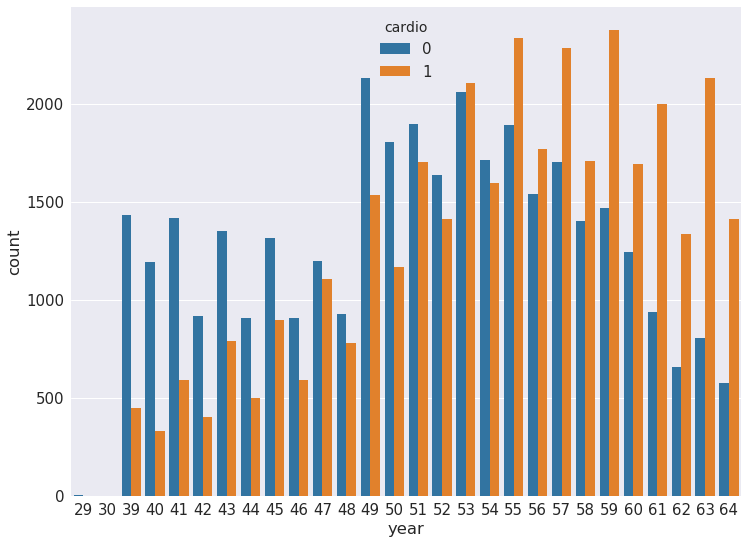

In [17]:
plt.figure(figsize=FIGSIZE_TUPLE)
sns.countplot(x="year", hue='cardio', data=train);

### 5. В каком возрасте количество пациентов с ССЗ  впервые становится больше, чем здоровых?
- 44
- 49
- **<font color='green'>53</font>**
- 62